
Training LightGBM Model...
Model Accuracy: 81.23%

Calculating SHAP values (using Explanation API)...
Saved: shap_summary_bar.png


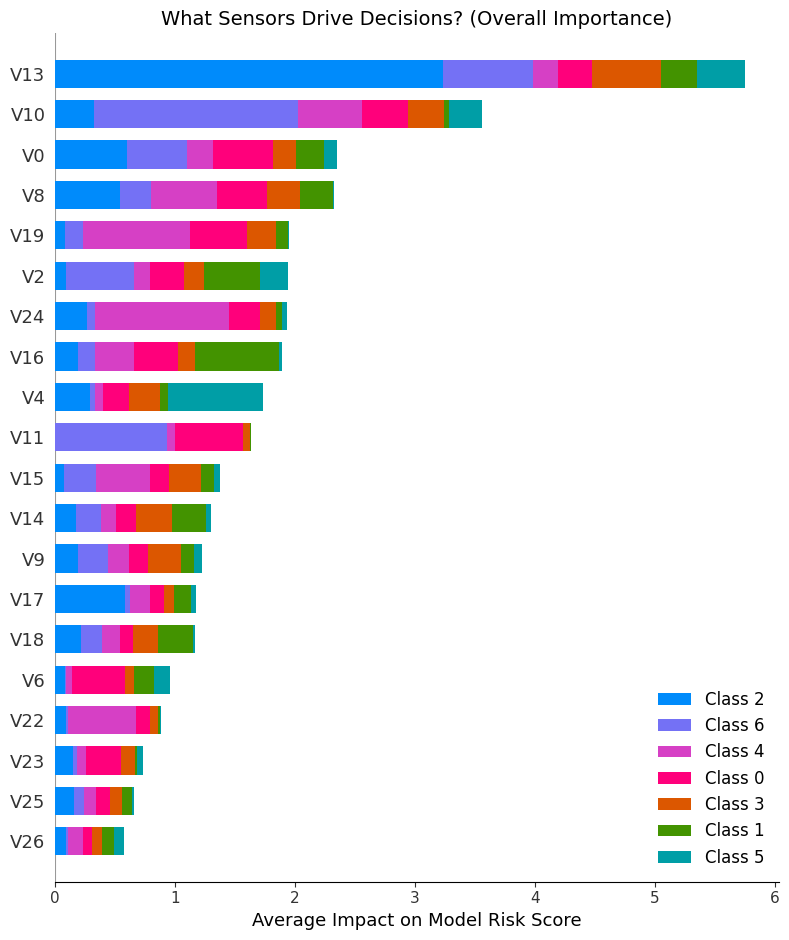

Saved: shap_stains_beeswarm.png


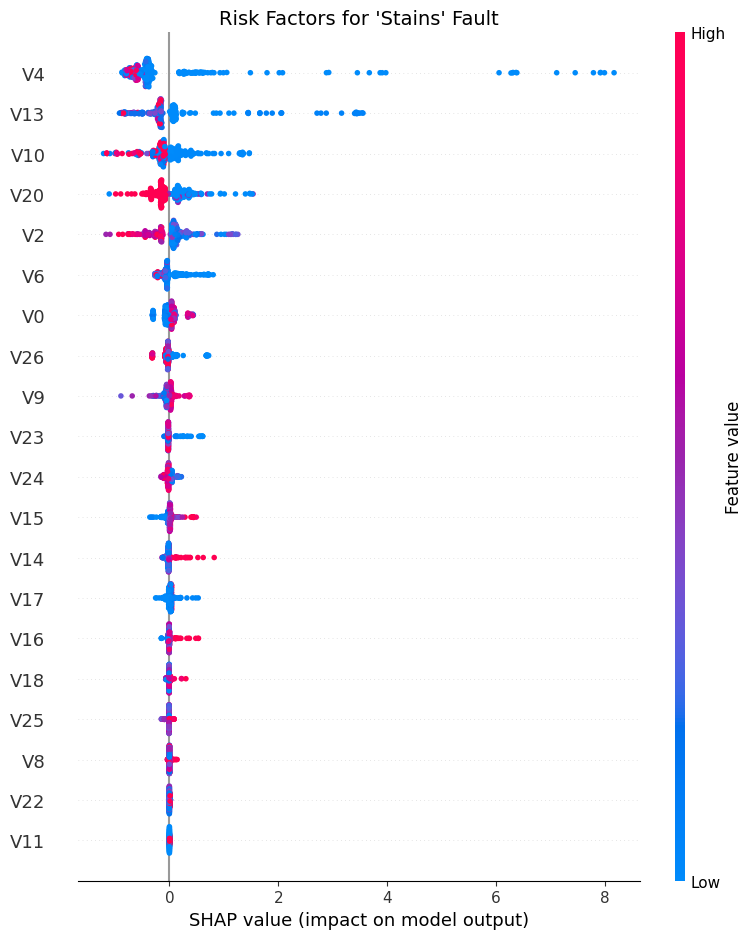

Saved: shap_dependence.png


<Figure size 800x600 with 0 Axes>

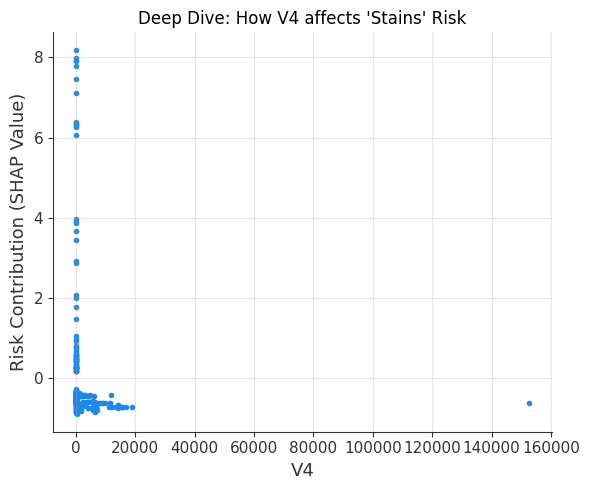

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import zipfile
import urllib.request
from io import BytesIO

# ---------------------------------------------------------
# 1. Setup & Data Loading
# ---------------------------------------------------------
DATA_URL = "https://archive.ics.uci.edu/static/public/198/steel+plates+faults.zip"
CLASS_NAMES = [
    "Pastry", "Z_Scratch", "K_Scatch", "Stains",
    "Dirtiness", "Bumps", "Other_Faults"
]

def fetch_and_process_data():
    print("Downloading data...")
    with urllib.request.urlopen(DATA_URL) as resp:
        with zipfile.ZipFile(BytesIO(resp.read())) as zf:
            target = next(n for n in zf.namelist() if "Faults.NNA" in n or "faults" in n.lower())
            with zf.open(target) as f:
                df = pd.read_csv(f, sep=r'\s+', header=None)

    # Preprocessing to match previous work
    feat_cols = [f"V{i}" for i in range(27)]
    df.columns = feat_cols + CLASS_NAMES

    # Filter invalid rows
    mask = df[CLASS_NAMES].sum(axis=1) == 1
    df_clean = df[mask].copy()

    X = df_clean[feat_cols]
    y_raw = df_clean[CLASS_NAMES].idxmax(axis=1)

    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    # Feature Selection
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X = X.drop(columns=to_drop)

    return X, y, le, X.columns.tolist()

# ---------------------------------------------------------
# 2. Train LightGBM Model
# ---------------------------------------------------------
X, y, le, feature_names = fetch_and_process_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining LightGBM Model...")
model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)
model.fit(X_train, y_train)
print(f"Model Accuracy: {accuracy_score(y_test, model.predict(X_test)):.2%}")

# ---------------------------------------------------------
# 3. SHAP Analysis (FIXED)
# ---------------------------------------------------------
print("\nCalculating SHAP values (using Explanation API)...")
explainer = shap.TreeExplainer(model)

# FIX: Use the explainer(X) call syntax instead of shap_values(X).
# This returns an Explanation object that handles dimensions robustly.
shap_obj = explainer(X_test)

# For Multiclass: shap_obj.values is (n_samples, n_features, n_classes)
# We need to extract the specific slice for "Stains"
stains_index = list(le.classes_).index('Stains')

# Extract specific explanation for Stains
# This keeps it as an Explanation object (safe for plotting)
stains_explanation = shap_obj[:, :, stains_index]

# Create list of arrays for the global summary plot (Bar chart needs list for multiclass)
shap_values_list = [shap_obj.values[:,:,i] for i in range(shap_obj.values.shape[2])]

# ---------------------------------------------------------
# 4. Plots
# ---------------------------------------------------------

# Plot A: Summary Plot (Global Importance) - All Classes
plt.figure(figsize=(10, 6))
plt.title("What Sensors Drive Decisions? (Overall Importance)", fontsize=14)
# Note: For multi-class bar plot, we pass the list of values
shap.summary_plot(shap_values_list, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
plt.xlabel("Average Impact on Model Risk Score")
plt.tight_layout()
plt.savefig('shap_summary_bar.png')
print("Saved: shap_summary_bar.png")
plt.show()

# Plot B: Beeswarm Plot - Specifically for 'Stains'
plt.figure(figsize=(10, 6))
plt.title(f"Risk Factors for 'Stains' Fault", fontsize=14)
# Pass the Explanation object directly
shap.summary_plot(stains_explanation, X_test, show=False)
plt.tight_layout()
plt.savefig('shap_stains_beeswarm.png')
print("Saved: shap_stains_beeswarm.png")
plt.show()

# Plot C: Dependence Plot - Top Feature for Stains
# Find top feature for Stains
# Calculate mean absolute SHAP value for each feature
mean_shap = np.abs(stains_explanation.values).mean(axis=0)
top_feature_idx = mean_shap.argmax()
top_feature_name = X_test.columns[top_feature_idx]

plt.figure(figsize=(8, 6))
# For dependence plot, we can use the values and data directly
shap.dependence_plot(
    top_feature_name,
    stains_explanation.values,
    X_test,
    interaction_index=None,
    show=False
)
plt.title(f"Deep Dive: How {top_feature_name} affects 'Stains' Risk", fontsize=12)
plt.ylabel("Risk Contribution (SHAP Value)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('shap_dependence.png')
print("Saved: shap_dependence.png")
plt.show()